# Imports

In [2]:
!pip install -U -q PyDrive

import os, shutil
from os import path
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
from keras import models 
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd 
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed
from numpy.random import seed
seed(1)

# Download Data

In [3]:
#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#Choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

#Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1tQbRH3uO-mwTbViQTNdzs_4x-UnUkoSz' in parents"}).GetList()

for f in file_list:
  #Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: Leukimia_DS.zip, id: 1Jk8GEaHikkiM9agFEh8VQTUtWcRzpWOk
downloading to /root/data/Leukimia_DS.zip
title: Leukimia_DS.rar, id: 1dRsKV5y7eL0Gv__FNCdlWvEzzUcox1tv
downloading to /root/data/Leukimia_DS.rar
title: DLProject.ipynb, id: 1oUqNUTcs9utjRoTmOUuF7yEMyg2o3PyO
downloading to /root/data/DLProject.ipynb


In [5]:
with zipfile.ZipFile('/root/data/Leukimia_DS.zip', 'r') as zip_ref:
    zip_ref.extractall('/root/data')

# Data Preprocessing

In [ ]:
#The data didn't come all in the same format, the "test" set didn't have labels, so we eliminated it and
#created a new test set, and the validation set didn't come in folders seperated by class, so we used
#the following code to put it on that format. And then we zipped the data, uploaded it to a drive and
#started using that file

#Since the original test set had to be deleted, we decided to create new splits, having about 10000 images
#for train, 3000 for validation and 3000 for test

#data= pd.read_csv('C-NMC_test_prelim_phase_data_labels.csv')

#lista=list(range(1,len(data)+1)
#data['Names']=lista
#ALLdata=data[data['labels']==1]
#HMEdata=data[data['labels']==0]

#src = "Desktop/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"
#dst = "Desktop/Leukimia DS/Val/ALL"

#for j in range(len(ALLdata)):
#    files = [i for i in os.listdir(src) if i.startswith(ALLdata['Names'].iloc[j].astype(str)) and path.isfile(path.join(src, i))]
#    for f in files:
#        shutil.copy(path.join(src, f), dst)

#src = "Desktop/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"
#dst = "Desktop/Leukimia DS/Val/HEM"

#for j in range(len(HMEdata)):
#    files = [i for i in os.listdir(src) if i.startswith(HMEdata['Names'].iloc[j].astype(str)) and path.isfile(path.join(src, i))]
#    for f in files:
#        shutil.copy(path.join(src, f), dst)

In [7]:
import cv2
import glob
import numpy as np

X_data = []
files = glob.glob ("/root/data/Leukimia DS/Train/ALL/*.bmp")
for myFile in files:
    image = cv2.imread(myFile)
    print(image.shape)
    X_data.append(image)
    break

(450, 450, 3)


In [44]:
X2_data = []
files = glob.glob ("/root/data/Leukimia DS/Train/HEM/*.bmp")
for myFile in files:
    image = cv2.imread(myFile)
    X2_data.append(image)

In [47]:
y = []
for i in range(len(X_data)):
  y.append(1)
y2 = []
for i in range(len(X2_data)):
  y.append(0)

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
train_set = train_datagen.flow_from_directory('/root/data/Leukimia DS/Train/', 
                                                 target_size = (150, 150),
                                                 batch_size = 20,
                                                 class_mode = 'binary',
                                                shuffle = False)

val_set = test_datagen.flow_from_directory('/root/data/Leukimia DS/Val/', 
                                            target_size = (150, 150),
                                            batch_size = 20,
                                            class_mode = 'binary',
                                           shuffle = False)

test_set = test_datagen.flow_from_directory('/root/data/Leukimia DS/Test/', 
                                            target_size = (150, 150),
                                            batch_size = 20,
                                            class_mode = 'binary',
                                           shuffle = False)

Found 10661 images belonging to 2 classes.
Found 3144 images belonging to 2 classes.
Found 3553 images belonging to 2 classes.


# Model Creation and Training

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [31]:
hist= model.fit(
        train_set,
        steps_per_epoch= 250,
        epochs= 30,
        validation_data=test_set,
        validation_steps=150,
        )

Epoch 1/30
250/250 [==============================] - 224s 890ms/step - loss: 31.5082 - acc: 0.6907 - val_loss: 3.9347 - val_acc: 0.8573
Epoch 2/30
250/250 [==============================] - 222s 889ms/step - loss: 2.7926 - acc: 0.7322 - val_loss: 1.3526 - val_acc: 0.8563
Epoch 3/30
250/250 [==============================] - 222s 890ms/step - loss: 1.4236 - acc: 0.7488 - val_loss: 1.1971 - val_acc: 0.7570
Epoch 4/30
250/250 [==============================] - 221s 885ms/step - loss: 1.1037 - acc: 0.7635 - val_loss: 0.7916 - val_acc: 0.8730
Epoch 5/30
250/250 [==============================] - 221s 885ms/step - loss: 0.9535 - acc: 0.7696 - val_loss: 0.7248 - val_acc: 0.8413
Epoch 6/30
250/250 [==============================] - 222s 889ms/step - loss: 0.8721 - acc: 0.7668 - val_loss: 0.7030 - val_acc: 0.8200
Epoch 7/30
250/250 [==============================] - 222s 886ms/step - loss: 0.8182 - acc: 0.7728 - val_loss: 0.6079 - val_acc: 0.8700
Epoch 8/30
250/250 [===========================

# Model Assessment

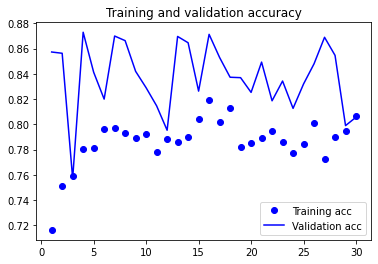

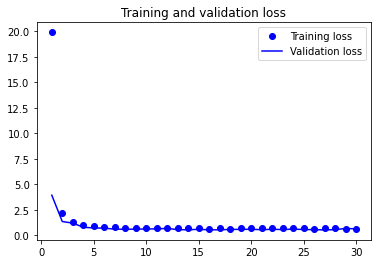

In [32]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model.save('test.h5')

In [ ]:
Y_pred = model.predict(val_set,63) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(val_set.classes, Y_pred))
print('Classification Report')
target_names = ['PlaceHolder', 'PlaceHolder']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[164  70]
 [  5 385]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.97      0.70      0.81       234
   PNEUMONIA       0.85      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624

